# Композиционная теория игр и нейросети: эксперимент

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru

In [1]:
pip install torch torchvision 'numpy<2'


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Данные

In [1]:
from dataclasses import dataclass

import torch

from torchvision import datasets, transforms

@dataclass
class Dataset:
    train_dataset: datasets.MNIST
    test_dataset: datasets.MNIST
    train_loader: torch.utils.data.DataLoader
    test_loader: torch.utils.data.DataLoader

def make_dataset(root: str, batch_size: int) -> Dataset:
    transform = transforms.Compose([
        transforms.ToTensor(),
        # https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(
        root=root,
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.MNIST(
        root=root,
        train=False,
        download=True,
        transform=transform
    )

    return Dataset(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        train_loader=torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        ),
        test_loader=torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
    )

dataset = make_dataset(root='./data', batch_size=64)


C:\Users\Ivan\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ivan\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Ivan\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



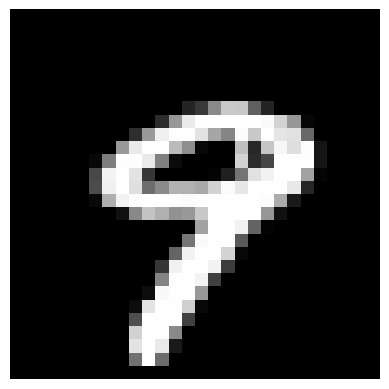

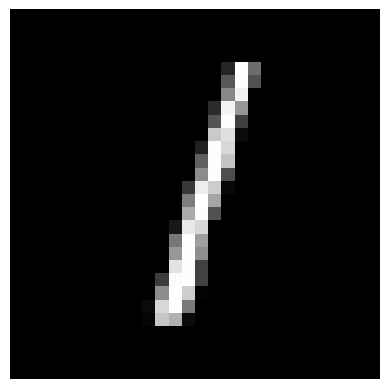

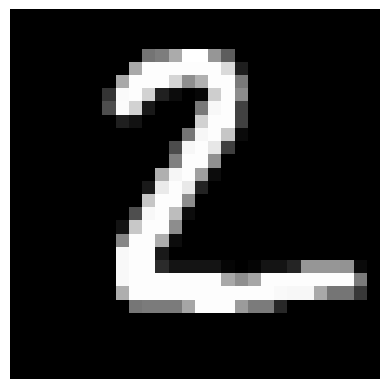

In [2]:
import matplotlib.pyplot as plt

def draw(tensor: torch.Tensor):
    plt.imshow(tensor, cmap='gray')
    plt.axis('off')
    plt.show()

draw(dataset.test_dataset.data[9])
draw(dataset.test_dataset.data[2])
draw(dataset.test_dataset.data[1])

## Модели

In [18]:
import torch

class CustomBackwardFunction(torch.autograd.Function):
    @staticmethod
    def forward(
        ctx,
        p: float,
        input: torch.Tensor,
        weight: torch.Tensor,
        bias: float = None
    ):
        ctx.save_for_backward(torch.scalar_tensor(p), input, weight, bias)

        output = input.mm(weight.t())
        if bias is not None:
            output += bias

        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input, weight, bias = ctx.saved_tensors

        height = weight.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1-p.item()))
 
        diagonal_mask = torch.diag(bernoulli_mask)/(1-p.item())

        grad_output = grad_output.mm(diagonal_mask)

        grad_input = grad_output.mm(weight)
        grad_weight = grad_output.t().mm(input)

        if bias is not None:
            grad_bias = grad_output.sum(0)
        else:
            grad_bias = None

        return None, grad_input, grad_weight, grad_bias


In [19]:
import torch.nn as nn
import torch.nn.functional as F

class DigitRecognizer(nn.Module):
    """
    Нейросеть с обычными линейными слоями.
    """
    def __init__(self):
        super(DigitRecognizer, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(28 * 28, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


class DigitRecognizerCustomBackward(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки.
    """
    def __init__(self):
        super(DigitRecognizerCustomBackward, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(28 * 28, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, 10)

        self.custom_backward = CustomBackwardFunction.apply

    def forward(self, x):
        x = self.flatten(x)
        x = self.custom_backward(0.05, x, self.fc1.weight, self.fc1.bias)
        x = F.relu(x)
        x = self.custom_backward(0.05, x, self.fc2.weight, self.fc2.bias)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## Обучение

E1/5 S100/938 Loss=0.4695
E1/5 S200/938 Loss=0.2255
E1/5 S300/938 Loss=0.1898
E1/5 S400/938 Loss=0.1750
E1/5 S500/938 Loss=0.1600
E1/5 S600/938 Loss=0.1563
E1/5 S700/938 Loss=0.1283
E1/5 S800/938 Loss=0.1290
E1/5 S900/938 Loss=0.1082
E2/5 S100/938 Loss=0.0949
E2/5 S200/938 Loss=0.1008
E2/5 S300/938 Loss=0.0871
E2/5 S400/938 Loss=0.0840
E2/5 S500/938 Loss=0.0923
E2/5 S600/938 Loss=0.0944
E2/5 S700/938 Loss=0.0846
E2/5 S800/938 Loss=0.0922
E2/5 S900/938 Loss=0.0925
E3/5 S100/938 Loss=0.0565
E3/5 S200/938 Loss=0.0649
E3/5 S300/938 Loss=0.0573
E3/5 S400/938 Loss=0.0612
E3/5 S500/938 Loss=0.0771
E3/5 S600/938 Loss=0.0651
E3/5 S700/938 Loss=0.0647
E3/5 S800/938 Loss=0.0577
E3/5 S900/938 Loss=0.0655
E4/5 S100/938 Loss=0.0441
E4/5 S200/938 Loss=0.0399
E4/5 S300/938 Loss=0.0505
E4/5 S400/938 Loss=0.0391
E4/5 S500/938 Loss=0.0503
E4/5 S600/938 Loss=0.0572
E4/5 S700/938 Loss=0.0618
E4/5 S800/938 Loss=0.0569
E4/5 S900/938 Loss=0.0464
E5/5 S100/938 Loss=0.0356
E5/5 S200/938 Loss=0.0376
E5/5 S300/93

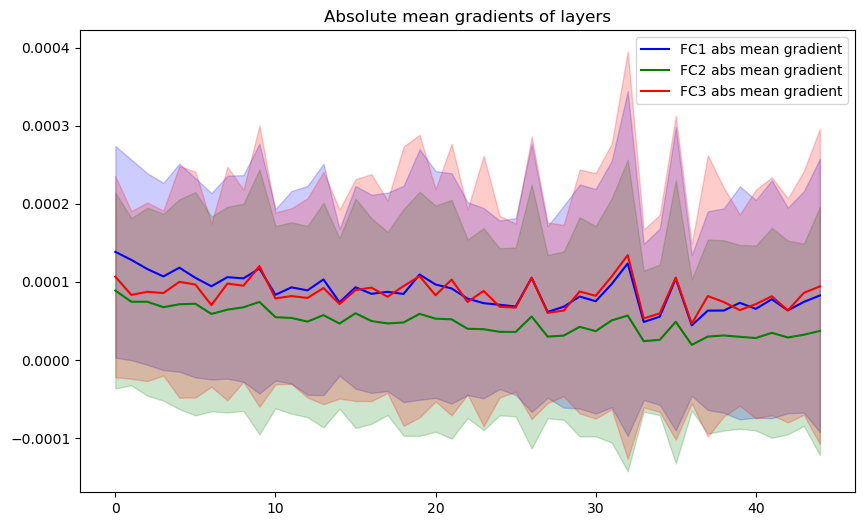

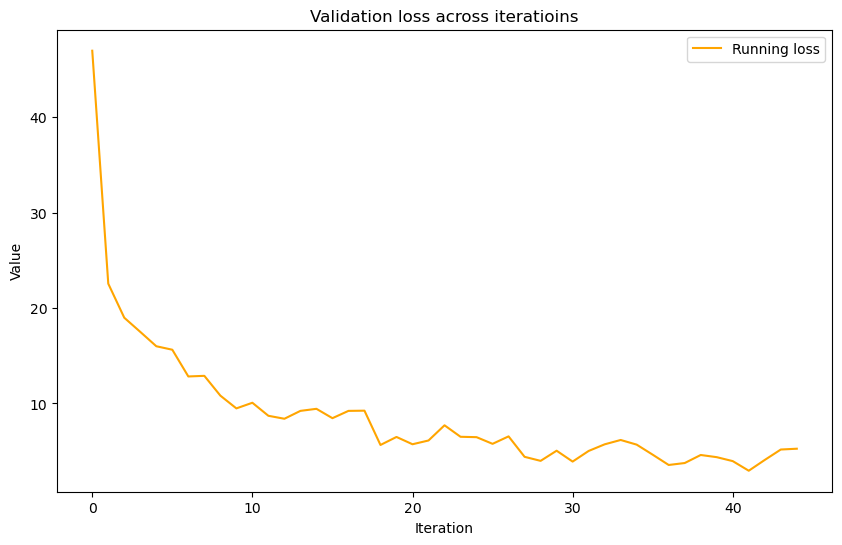

E1/5 S100/938 Loss=0.4796
E1/5 S200/938 Loss=0.2303
E1/5 S300/938 Loss=0.1970
E1/5 S400/938 Loss=0.1648
E1/5 S500/938 Loss=0.1513
E1/5 S600/938 Loss=0.1637
E1/5 S700/938 Loss=0.1492
E1/5 S800/938 Loss=0.1257
E1/5 S900/938 Loss=0.1134
E2/5 S100/938 Loss=0.0977
E2/5 S200/938 Loss=0.0950
E2/5 S300/938 Loss=0.0980
E2/5 S400/938 Loss=0.0824
E2/5 S500/938 Loss=0.1049
E2/5 S600/938 Loss=0.0988
E2/5 S700/938 Loss=0.0811
E2/5 S800/938 Loss=0.0965
E2/5 S900/938 Loss=0.0808
E3/5 S100/938 Loss=0.0542
E3/5 S200/938 Loss=0.0576
E3/5 S300/938 Loss=0.0649
E3/5 S400/938 Loss=0.0597
E3/5 S500/938 Loss=0.0731
E3/5 S600/938 Loss=0.0713
E3/5 S700/938 Loss=0.0711
E3/5 S800/938 Loss=0.0683
E3/5 S900/938 Loss=0.0696
E4/5 S100/938 Loss=0.0471
E4/5 S200/938 Loss=0.0447
E4/5 S300/938 Loss=0.0468
E4/5 S400/938 Loss=0.0487
E4/5 S500/938 Loss=0.0459
E4/5 S600/938 Loss=0.0517
E4/5 S700/938 Loss=0.0612
E4/5 S800/938 Loss=0.0489
E4/5 S900/938 Loss=0.0587
E5/5 S100/938 Loss=0.0353
E5/5 S200/938 Loss=0.0343
E5/5 S300/93

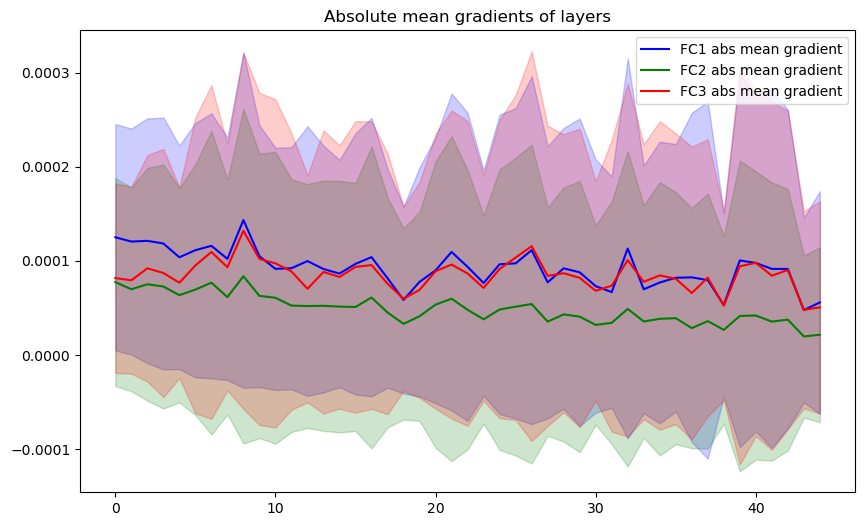

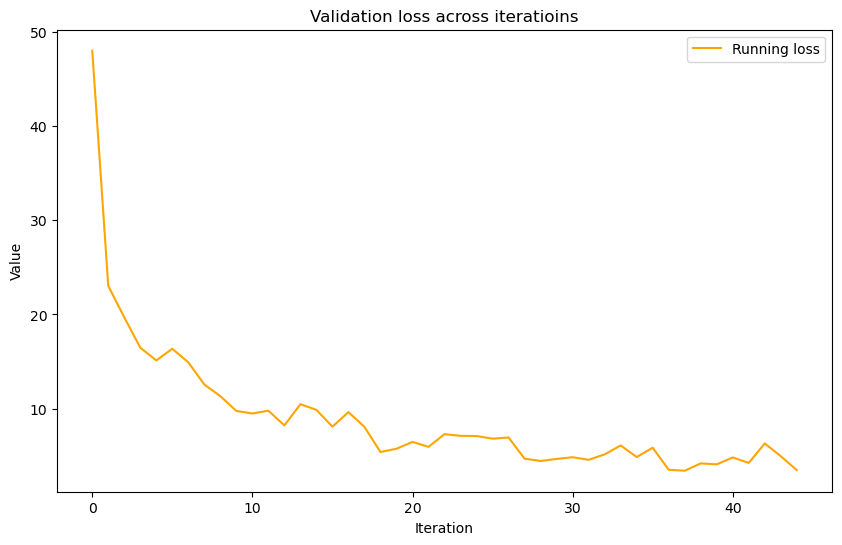

In [20]:
import torch.optim as optim

def dabs_mean_std(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor
):
    dabs: torch.Tensor = torch.abs(tensor2 - tensor1)

    mean = torch.mean(dabs)
    std = torch.std(dabs)

    return (mean.item(), std.item())


def train(model: DigitRecognizer, loader, epochs, criterion, optimizer):
    # Наблюдаемые величины
    running_losses: list[float] = []
    fc1_dabs_mean: list[float] = []
    fc1_dabs_std: list[float] = []
    fc2_dabs_mean: list[float] = []
    fc2_dabs_std: list[float] = []
    fc3_dabs_mean: list[float] = []
    fc3_dabs_std: list[float] = []

    for epoch in range(epochs):
        running_loss = 0.0

        model.train()

        for i, (inputs, labels) in enumerate(loader):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            fc1_weight = model.fc1.weight.clone()
            fc2_weight = model.fc2.weight.clone()
            fc3_weight = model.fc3.weight.clone()

            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                (mean1, std1) = (dabs_mean_std(fc1_weight, model.fc1.weight))
                fc1_dabs_mean.append(mean1)
                fc1_dabs_std.append(std1)

                (mean2, std2) = (dabs_mean_std(fc2_weight, model.fc2.weight))
                fc2_dabs_mean.append(mean2)
                fc2_dabs_std.append(std2)

                (mean3, std3) = (dabs_mean_std(fc3_weight, model.fc3.weight))
                fc3_dabs_mean.append(mean3)
                fc3_dabs_std.append(std3)

                print(f'E{epoch + 1}/{epochs} S{i + 1}/{len(loader)} Loss={running_loss / 100:.4f}')
                running_losses.append(running_loss)
                running_loss = 0.0

    X = range(len(fc1_dabs_mean))

    def plot_mean_std(label, color, series_mean, series_std):
        plt.plot(X, series_mean, label=label, color=color)

        plt.fill_between(
            X,
            [m - s for m, s in zip(series_mean, series_std)],
            [m + s for m, s in zip(series_mean, series_std)],
            color=color,
            alpha=0.2
        )

    plt.figure(figsize=(10, 6))
    plot_mean_std('FC1 abs mean gradient', 'blue', fc1_dabs_mean, fc1_dabs_std)
    plot_mean_std('FC2 abs mean gradient', 'green', fc2_dabs_mean, fc2_dabs_std)
    plot_mean_std('FC3 abs mean gradient', 'red', fc3_dabs_mean, fc3_dabs_std)
    plt.title('Absolute mean gradients of layers')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(X, running_losses, label='Running loss', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Validation loss across iteratioins')
    plt.legend()
    plt.show()


model1 = DigitRecognizer()

train(
    model=model1,
    loader=dataset.train_loader,
    epochs=5,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(
        model1.parameters(),
        lr=0.001
    )
)

torch.save(model1.state_dict(), 'digit_recognizer1.pth')

model2 = DigitRecognizerCustomBackward()

train(
    model=model2,
    loader=dataset.train_loader,
    epochs=5,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(
        model2.parameters(),
        lr=0.001
    )
)

torch.save(model2.state_dict(), 'digit_recognizer2.pth')



## Валидация

In [25]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score

def evaluate_model(path: str):
    evaluated_model = DigitRecognizerCustomBackward()
    evaluated_model.load_state_dict(torch.load(path))

    evaluated_model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataset.test_loader:
            outputs = evaluated_model(inputs + torch.randn(inputs.shape)*0.05)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    roc_auc = 1 #roc_auc_score(all_labels, all_probs)

    return accuracy, f1, roc_auc

path = 'digit_recognizer1.pth'
accuracy, f1, roc_auc = evaluate_model(path)
print('Обычная модель')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

path = 'digit_recognizer2.pth'
accuracy, f1, roc_auc = evaluate_model(path)
print('Модель с переопределённым распространением ошибки')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

Обычная модель
Accuracy: 97.69%
F1 Score: 0.9769
ROC-AUC: 1.0000
Модель с переопределённым распространением ошибки
Accuracy: 97.53%
F1 Score: 0.9753
ROC-AUC: 1.0000


## Предсказания

In [ ]:
import torch
model1 = DigitRecognizer()
model1.load_state_dict(torch.load('digit_recognizer2.pth'))

idx = 1000

draw(dataset.test_dataset.data[idx])

(X, y) = dataset.test_dataset[idx]

outputs = model1(X)
_, predicted = torch.max(outputs.data, 1)
print(outputs[0])

(y, predicted)
